# News Cycle Study

## Purpose

The "news cycle" is not necessarily a well-defined concept. Traditionally, a news cycle has been defined as "the amount of time that passes between the release of one edition of a news outlet and the follow up edition", a notion almost rendered moot by the advent of the 24-hour news cycle where newsworthy events are reported almost immediately after they occur, no matter the day or time [[Wisegeek](http://www.wisegeek.com/what-is-a-news-cycle.htm)]. Conscious of this, some modern sources conceive of a news cycle not in terms of time, but rather in terms of how news is 'processed' by the media. Slate.com's Jack Shafer describes the news cycle as consisting of three phases: 

> To him, “24 hour news cycle” refers to three phases of news. “Overnight, newspapers launch the news,” Shafer wrote. “They publish stories clarifying the events of yesterday; they break their own investigative stories; they print zeitgeist-defining feature articles and op-eds." The morning brings phase two, when “Web media critics [like bloggers and commenters] react to the news." Phrase three, Shafer said, is “the buildup, [which] comes in the afternoon, as the events of the day unfold … Opinion makers try to shape how the day's events will play on the night's cable shows and in tomorrow's newspapers. The next morning, it all starts over again." [[PR Daily](https://www.prdaily.com/Main/Articles/What_does_24_hour_news_cycle_actually_mean_222.aspx)]

[Oxford's Living Dictionary's](https://en.oxforddictionaries.com/definition/news_cycle) definition seems to capture these subtly distinct meanings best: a news cycle is simply "a round of media coverage". It's media activity surrounding a story from the moment it becomes "news" and begins getting media coverage, to the moment it stops. 

Having embraced this conception of the news cycle, we wondered just how long a news cycle is - how long does it take for the media to start and stop talking about an event? - and how the length of this period has changed over the years. The question is important because widespread media coverage of events like earthquakes or political events is thought to both reflect and play a key part in defining what the broader public is aware and attentive to. Shifts over the years in the duration of coverage of various types of events can potentially help explain concomitant changes in a broad variety of social phenomena. 

With this project, **we sought to quantify and understand how the length of time it takes for this sort of media activity surrounding a story to start and stop has changed over the years**. We examined this question by sampling events from various databases and searching newspaper archives for coverage related to those events, counting articles and tracking the date upon which they were published. Intuitively, coverage of an event will tend to peak around when the event first happens, and then drop quickly as time goes by. But the pace of the drop and other aspects of this pattern can have broad variability depending on countless factors. For now we focus on just one of these - an event's date. Our methods and results are detailed below.

## Methodology (Needs Updating)

The data components of a project like ours are twofold. First, we take a database of many similar events that have occurred over several decades. Second, for each event in the database, we search a database of news archives to measure media coverage of the event succeeding its happening. In this section, we describe the data sets used to drive our project as well as the steps we took to utilitize them systematically.

#### Database Details:
- The Global Terrorism Database (GTD) - https://www.start.umd.edu/gtd/about/
- The International Disasters Database (EM-DAT) - http://www.emdat.be/explanatory-notes
- The ProQuest Historical Newspapers™ Archive - http://proquest.libguides.com/hnp

Notes: GTD is missing 1993 data. EM-DAT goes back further than 1970.

#### Event Inclusion Criteria
- the event happened in the USA
- the event happened between 1970 and 2015 inclusive
- have an event location in the database more specific than nation (**GTD events always met this criteria; EM-DAT less reliable**)
- news article search for the event had to return at least one result (**note: should i count 0-article events?**)
- if a terrorist attack, the event had to meet all three GTD criteria for terrorism (**note: may soon alter to 1**)
- if a terrorist attack, it had to be successful (**note: may soon not require a successful attack**)

#### Search Strategy
GTD event search term:
> (attack_location) AND ((shooting) OR (bombing) OR (bomb) OR (violence) OR (murder) OR (terrorism)) AND (date_range)

Where attack_location specifies where the attack occurred and date_range specifies the first 50 days after the attack, including the day of the attack.

EM-DAT search term:
> (disaster_location) AND (one_of_these_labels) AND (date_range)

Where disaster_location specifies where the disaster occurred, and date_range specifies the first 50 days after the attack, including the day of the attack, and one_of_these_labels denotes the set of event labels pulled from the event's disaster type, disaster subtype and related associated entries within the EM-DAT.

Results were sorted oldest first, required to be in english and available in full text from the databse, and had duplicates removed before being returned. 

## Dependencies and Preprocessing
If pulling data from web,  values of other variables don't really matter.

In [ ]:
#@title  { form-width: "500px" }
# initial parameters
pullDataFromWeb = True #@param {type:"boolean"}
datapath = "C:/Users/jgunn/Google Drive/newsrepo/newscycle/data/" #@param {type:"string"}
articlespath = "D:/decembercycle/articles/" #@param {type:"string"}
eventspath = "D:/decembercycle/events/" #@param {type:"string"}
preprocessNewArticles = "No (the current dataset is already processed)" #@param ["Yes", "No (the current dataset is already processed)"]

# dependencies
import warnings
warnings.filterwarnings("ignore")

import os
import json
import math
import numpy as np
import datetime
from datetime import timedelta
import csv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import seaborn as sns
sns.set_style("darkgrid")

sources = ['cleanedarticles1.jl', 'cleanedarticles2.jl','cleanedarticles3.jl', 
           'cleanedarticles4.jl', 'cleanedarticlesJanuary.jl']

# helper functions
def loadFromRepo(scriptpath):
    import requests
    url = 'https://cdn.rawgit.com/puhseechee/newsrepo/70986dab/newscycle/data/{}'
    url = url.format(scriptpath)
    return requests.get(url).text

# a bootstrapping function
def bootstrapCI(x, estimator, nIter, *args):
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x), len(x))
        try:
            boot = np.array(x)[inds]
        except TypeError:
            print(x.dtype)
            assert(2==1)
        u.append(estimator(boot, *args))

    p1 = len([i for i in u if i < 0]) / len(u) * 2
    p2 = len([i for i in u if i > 0]) / len(u) * 2
    p = np.min([p1, p2])
    U = np.mean(u)
    lb = np.percentile(u, 2.5)
    ub = np.percentile(u, 97.5)
    return U, lb, ub, p

# constant of proportionality fitting
def func(x, a, b):
    return a/x + b

# wrapper of curve_fit function to make it compatible with bootstrapCI
def wrapped_curve_fit(articlecounts, daterange, function):
    try:
        popt, pcov = curve_fit(function, daterange, articlecounts)
        return popt[0]
    except (RuntimeError, ValueError):
        return np.nan

# and...go!
if pullDataFromWeb:
    pass
else:
    f = open(os.path.join(eventspath, 'terrorism.csv'), encoding="utf8")
    terrorism = [c for c in csv.reader(f)]
    f.close()
    header = terrorism[0]

"""Instead of putting the entire articles.jl file(s) into space, 
something that could create memory issues and take a lot of time, 
let's do preprocessing of those files line by line to create the values 
we're interested in scrutinizing. This way I never have to experience the 
pain of loading cleanedarticles1.jl again unless it's for a new analysis. 
And I can dynamically render results in realtime once I setup the right widgets.
"""

if preprocessNewArticles == 'Yes':
    result = {}

    for source in reversed(sources):
        print(source)
        counter = 0
        f = open(os.path.join(articlespath, source))
        for line in f:
            counter += 1
            article = json.loads(line)
            index = article['databaseindex']

            # if a new event, we set up a new dictionary entry before populating
            if index not in result:

                # try to store the event date; give up if we can't
                try:
                    event = terrorism[index-1]
                    result[index] = {'eventdate': datetime.datetime(
                        int(event[header.index('iyear')]), # date of event
                        int(event[header.index('imonth')]),
                        int(event[header.index('iday')]))}
                except ValueError:
                    continue

                # initialize countsbyday vector for all sources
                for s in sources:
                    result[index][s] = [0]*51

            # try to update relevant countsbyday vector with event
            eventdate = result[index]['eventdate']
            articledate = article['daysFrom']
            try:
                daysFrom = datetime.datetime.strptime(
                    articledate[:articledate.find(' ')], '%Y-%m-%d')
                result[index][source][int((daysFrom-eventdate).days)]+=1
            except ValueError:
                continue

        f.close()
    
    # now save the result
    for r in result:
        result[r]['eventdate'] = str(result[r]['eventdate'])
    with open(os.path.join(datapath, 'articleCountsByDay.json'), 'w') as f:
        f.write(json.dumps(result))

#  Load Preprocessed Dataset
if pullDataFromWeb:
    articleCountsByDay = json.loads(loadFromRepo('articleCountsByDay.json'))
    attackYears = [int(y) for y in loadFromRepo('attackyears.txt').split('\t')]
    victimYears = [int(y) for y in loadFromRepo('victimyears.txt').split('\t')]
else:
    with open(os.path.join(datapath, 'articleCountsByDay.json'), 'r') as f:
        articleCountsByDay = json.loads(f.read())
    with open(os.path.join(datapath, 'attackyears.txt'), 'r') as f:
        attackYears = [int(y) for y in f.read().split('\t')]
    with open(os.path.join(datapath, 'victimYears.txt'), 'r') as f:
        victimYears = [int(y) for y in f.read().split('\t')]

## Data Overview
(A missing tick means no data for the corresponding year is included in the histogram. There is no GTD data for the year 1993.)  
(set excludeYears variables to 0 if not excluding any years)

**NOTE: Code in these cells will not run if you selected pullDataFromWeb above.**

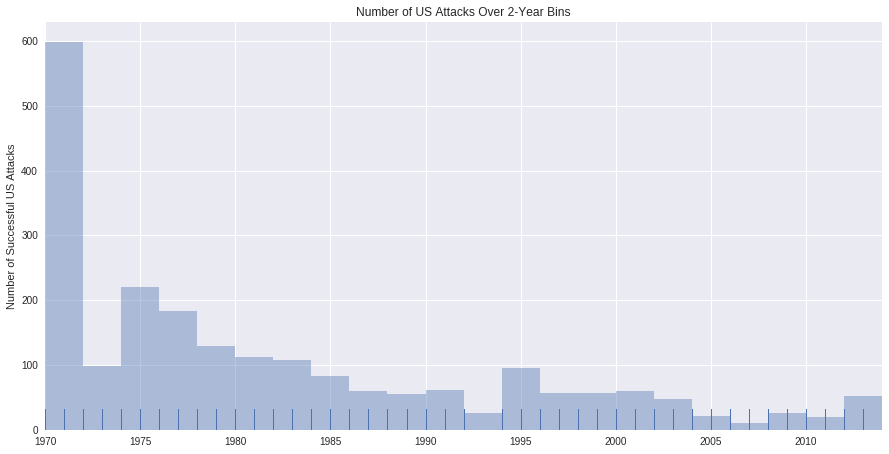

In [4]:
#@title What's the distribution of terrorist attacks over the years?
yearsPerBin = 2 #@param {type:"integer"}
excludeYearsBeginningAt = 0 #@param {type:"integer"}
excludeYearsEndingAt = 0 #@param {type:"integer"}
reprocessEventDatabase = "No (the current dataset is already processed)" #@param ["Yes", "No (the current dataset is already processed)"]

if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    assert(1970 <= excludeYearsBeginningAt <= excludeYearsEndingAt)
    assert(excludeYearsBeginningAt <= excludeYearsEndingAt <= 2016)

# generic starter variables
counter = 0  # for tracking position in database

# scan thru and store attack year for each event
if reprocessEventDatabase == 'Yes':
    attackYears = []
    for line in terrorism:

        # incr counter
        counter = counter + 1

        # store the header
        if counter == 1:
            header = line
            continue

        # skip this line if...
        if (
            # the attack wasn't in the US,
            line[header.index('country_txt')] != 'United States'
        ):
            # print 'attack wasn\'t in the US; row not included'
            continue

        if (
            # the attack didn't meet all criteria for terrorism,
            (line[header.index('crit1')] != '1') and
            (line[header.index('crit2')] != '1') and
            (line[header.index('crit3')] != '1')
           ):
            # print 'attack didn\'t meet all terrorism criteria; row not included'
            continue

        if (
            # the attack wasn't successful
            line[header.index('success')] != '1'
           ):
            # print 'attack wasn\'t successful; row not included'
            continue

        if (
            # the attack was in an excluded year range
            excludeYearsBeginningAt <= int(line[header.index('iyear')]) < excludeYearsEndingAt
           ):
            continue

        # grab the year
        attackYears.append(int(line[header.index('iyear')]))

# histogram of the result
decades = list(range(1970, 2016, yearsPerBin))
fig, ax = plt.subplots(figsize=(15, 7.5))
plot = sns.distplot(attackYears, bins=decades,ax=ax, kde=False, rug=True)
plot.set_xlim(min(decades), max(decades))
plot.set_ylabel('Year Bin')
plot.set_ylabel('Number of Successful US Attacks')
titlestring = 'Number of US Attacks Over {}-Year Bins'.format(yearsPerBin)
if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    titlestring += f' (Excluding {excludeYearsBeginningAt} to {excludeYearsEndingAt})'
plot.set_title(titlestring)
plt.show()

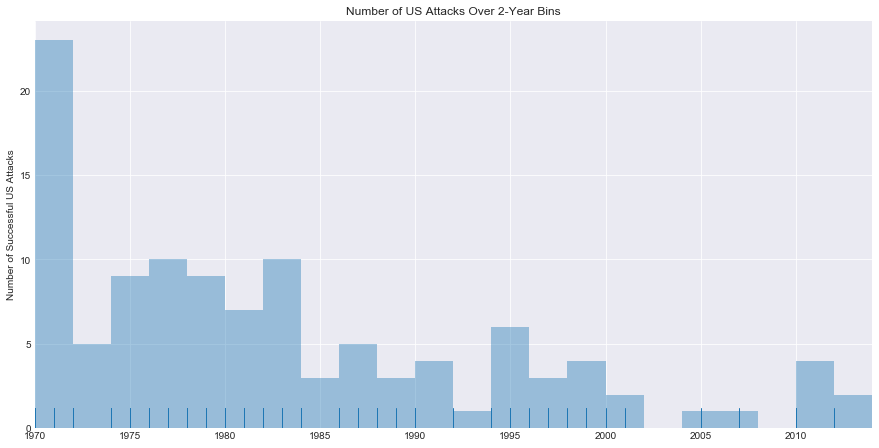

In [37]:
#@title What's the distribution of terrorist attacks with no articles found about them? (WON'T WORK ON WEB)
source = 'cleanedarticles2.jl' #@param {type:"string"}
yearsPerBin = 2 #@param {type:"integer"}
excludeYearsBeginningAt = 0 #@param {type:"integer"}
excludeYearsEndingAt = 0 #@param {type:"integer"}

if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    assert(1970 <= excludeYearsBeginningAt <= excludeYearsEndingAt)
    assert(excludeYearsBeginningAt <= excludeYearsEndingAt <= 2016)

# generic starter variables
counter = 0  # for tracking position in database

# scan thru and store attack year for each event
attackYears = []
for databaseindex, line in enumerate(terrorism):

    # incr counter
    counter = counter + 1

    # store the header
    if counter == 1:
        header = line
        continue

    # skip this line if...
    if (
        # the attack wasn't in the US,
        line[header.index('country_txt')] != 'United States'
    ):
        # print 'attack wasn\'t in the US; row not included'
        continue

    if (
        # the attack didn't meet all criteria for terrorism,
        (line[header.index('crit1')] != '1') and
        (line[header.index('crit2')] != '1') and
        (line[header.index('crit3')] != '1')
       ):
        # print 'attack didn\'t meet all terrorism criteria; row not included'
        continue

    if (
        # the attack wasn't successful
        line[header.index('success')] != '1'
       ):
        # print 'attack wasn\'t successful; row not included'
        continue

    if (
        # the attack was in an excluded year range
        excludeYearsBeginningAt <= int(line[header.index('iyear')]) < excludeYearsEndingAt
       ):
        continue

    if (
        # the attack had more than 0 articles written about it
        str(databaseindex+1) in articleCountsByDay
       ):
        if sum(articleCountsByDay[str(databaseindex+1)][source]) > 0:
            continue

    # grab the year
    attackYears.append(int(line[header.index('iyear')]))

# histogram of the result
decades = list(range(1970, 2016, yearsPerBin))
fig, ax = plt.subplots(figsize=(15, 7.5))
plot = sns.distplot(attackYears, bins=decades,ax=ax, kde=False, rug=True)
plot.set_xlim(min(decades), max(decades))
plot.set_ylabel('Year Bin')
plot.set_ylabel('Number of Successful US Attacks')
titlestring = 'Number of US Attacks Over {}-Year Bins'.format(yearsPerBin)
if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    titlestring += f' (Excluding {excludeYearsBeginningAt} to {excludeYearsEndingAt})'
plot.set_title(titlestring)
plt.show()

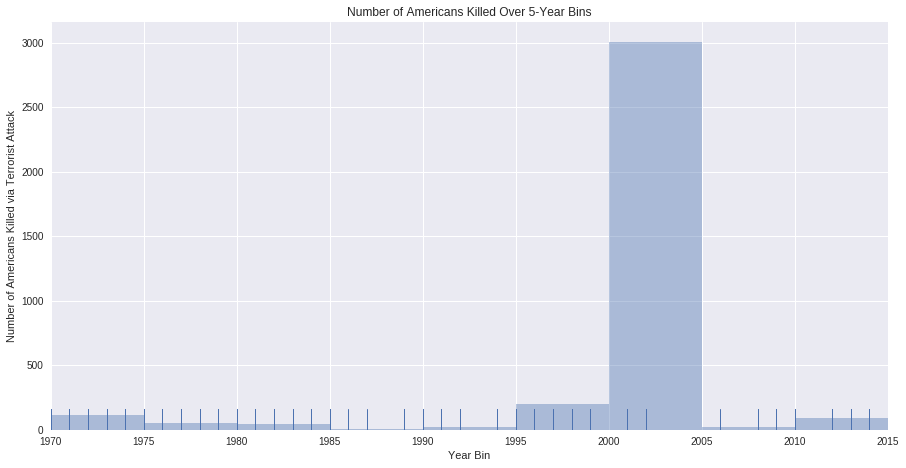

In [5]:
#@title How about the distribution of terrorist attack victims over the years?
yearsPerBin = 5 #@param {type:"integer"}
excludeYearsBeginningAt = 0 #@param {type:"integer"}
excludeYearsEndingAt = 0 #@param {type:"integer"}
reprocessEventDatabase = "No (the current dataset is already processed)" #@param ["Yes", "No (the current dataset is already processed)"]

if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    assert(1970 <= excludeYearsBeginningAt <= excludeYearsEndingAt)
    assert(excludeYearsBeginningAt <= excludeYearsEndingAt <= 2016)

# generic starter variables
counter = 0  # for tracking position in database

# scan thru and store attack year for each event
if reprocessEventDatabase == 'Yes':
    victimYears = []
    for line in terrorism:

        # incr counter
        counter = counter + 1

        # store the header
        if counter == 1:
            header = line
            continue

        # skip this line if...
        if (
            # the attack wasn't in the US,
            line[header.index('country_txt')] != 'United States'
        ):
            # print 'attack wasn\'t in the US; row not included'
            continue

        if (
            # the attack didn't meet all criteria for terrorism,
            (line[header.index('crit1')] != '1') and
            (line[header.index('crit2')] != '1') and
            (line[header.index('crit3')] != '1')
           ):
            # print 'attack didn\'t meet all terrorism criteria; row not included'
            continue

        if (
            # the attack wasn't successful
            line[header.index('success')] != '1'
           ):
            # print 'attack wasn\'t successful; row not included'
            continue

        if (
            # the attack was in an excluded year range
            excludeYearsBeginningAt <= int(line[header.index('iyear')]) < excludeYearsEndingAt
        ):
            continue

        # this time append the year for every victim of the attack
        nkill = line[header.index('nkill')]
        if nkill == '':
            nkill = 0
        for i in range(int(np.round(float(nkill)))):
            victimYears.append(int(line[header.index('iyear')]))

# histogram of the result
decades = list(range(1970, 2016, yearsPerBin))
fig, ax = plt.subplots(figsize=(15, 7.5))
plot = sns.distplot(victimYears, bins=decades,ax=ax, kde=False, rug=True)
plot.set_xlim(min(decades), max(decades))
plot.set_xlabel('Year Bin')
plot.set_ylabel('Number of Americans Killed via Terrorist Attack')
titlestring = f'Number of Americans Killed Over {yearsPerBin}-Year Bins'
if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
    titlestring += f' (Excluding {excludeYearsBeginningAt} to {excludeYearsEndingAt})'
plot.set_title(titlestring)
plt.show()

source: cleanedarticles1.jl:
	mean ~ 2715.369383092155
	standard deviation ~ 4044.1952448991115

source: cleanedarticles2.jl:
	mean ~ 1100.93145468393
	standard deviation ~ 2507.807770247558

source: cleanedarticles3.jl:
	mean ~ 196.6949733434882
	standard deviation ~ 971.4398854959512

source: cleanedarticles4.jl:
	mean ~ 18.374714394516374
	standard deviation ~ 135.27903700367327

source: cleanedarticlesJanuary.jl:
	mean ~ 1645.1923076923076
	standard deviation ~ 2970.5541529459433



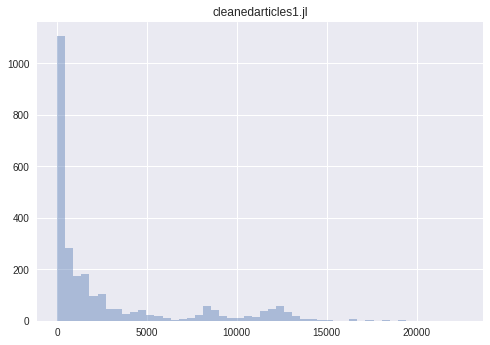

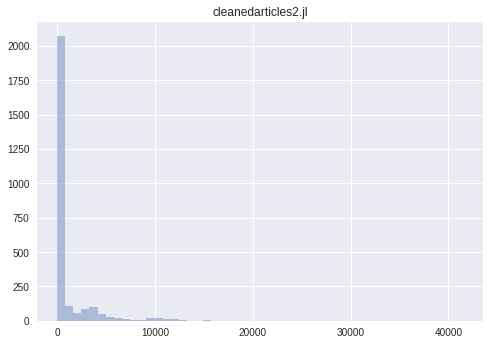

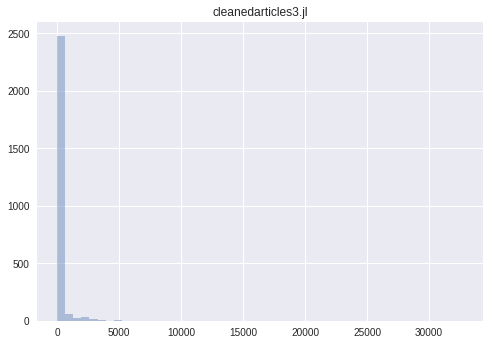

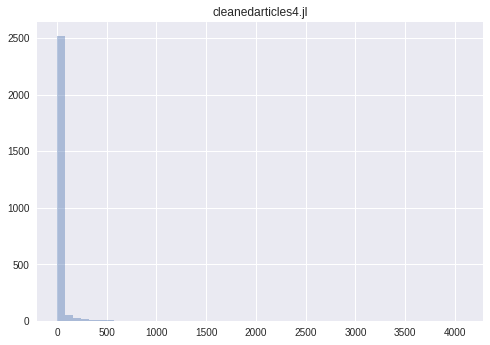

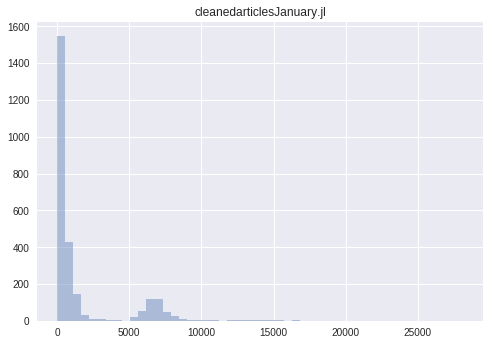

In [24]:
#@title The Mean/Standard Deviation/Distribution of Article Counts For Each Source
countZeroVectors = False #@param {type:"boolean"}
counts = {}

# for each source, store in a vector the number of articles counted for each event
for event in articleCountsByDay:
    for source in sources:
        if countZeroVectors and sum(articleCountsByDay[event][source]) == 0:
            continue
            
        if source in counts:
            counts[source].append(sum(articleCountsByDay[event][source]))
        else:
            counts[source] = [sum(articleCountsByDay[event][source])]

# print the mean, standard deviation for each source
# well, a histogram might be best
for source in counts:
    print('source: {}:\n\tmean ~ {}\n\tstandard deviation ~ {}\n'.format(
        source, np.mean(counts[source]), np.std(counts[source])))
    
# histogram
for source in counts:
    sns.distplot(counts[source], kde=False)
    plt.title(source)
    plt.show()

In [ ]:
#@title Render the Time Course of a Single Arbitrary Event in the Database
source = 'cleanedarticles4.jl' #@param {type:"string"}
databaseindex = 34 #@param {type:"integer"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
#databaseindex = str(databaseindex)

counter = 0
f = open(os.path.join(articlespath, source))
for line in f:
    counter += 1
    article = json.loads(line)
    index = article['databaseindex']
    if index == databaseindex:
        print(line)

## Specific Time Course Analyses

percentage: True
constant of proportionality:  -0.06499581448874503


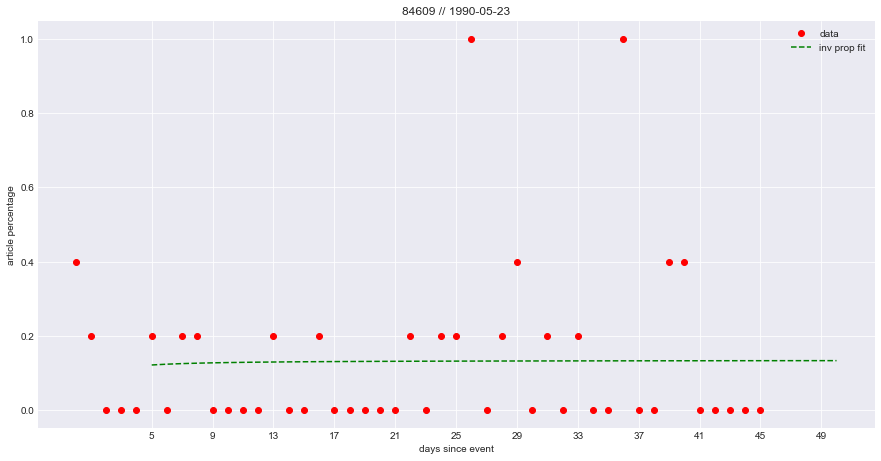

In [13]:
#@title Render the Time Course of a Single Arbitrary Event in the Database
source = 'cleanedarticles3.jl' #@param {type:"string"}
databaseindex = 84609 #@param {type:"integer"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
startAtFirstArticleInstead = False #@param {type:"boolean"}
databaseindex = str(databaseindex)

for percentage in [True]:
    print('percentage:', percentage)
    
    # get event information for contextualizing
    #event = terrorism[int(databaseindex)-1]
    #location = event[header.index('city')] + ', ' + event[header.index('provstate')]
    eventdate = articleCountsByDay[databaseindex]['eventdate']
    eventdate = eventdate[:eventdate.rfind(' ')]

    # data to plot
    articlecounts = articleCountsByDay[databaseindex][source]
    if startAtFirstArticleInstead:
        startday = next((i for i, x in enumerate(articlecounts[1:]) if x), None)+1
    articlecounts = articlecounts[startday:endday]
    if percentage:
        articlecounts = np.array(articlecounts)/max(articlecounts)

    # do it!
    fig, ax = plt.subplots(figsize=(15,7.5))
    ax.plot(articlecounts, 'ro', label='data')
    plt.ylabel('article {}'.format('percentage' if percentage else 'count'))
    plt.xlabel('days since event')
    plt.title(databaseindex + ' // ' + eventdate)
    
    try:
        popt, pcov = curve_fit(func, range(startday, endday), articlecounts)
        print ('constant of proportionality: ', popt[0])
        plt.plot(range(startday, endday), func(np.array(range(startday, endday)), *popt), 'g--', label='inv prop fit')
        plt.xticks(np.arange(startday, endday, 4), np.arange(startday, endday, 4))
        plt.legend()
        plt.show()

    except RuntimeError:
        print('Could not fit.')
        plt.legend()
        plt.show()

constant of proportionality:  -0.16934040944592632


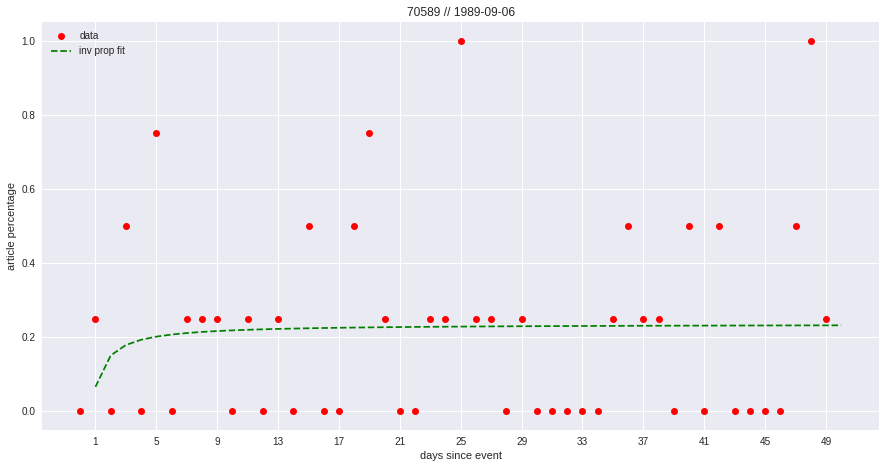

constant of proportionality:  -0.1755419138306531


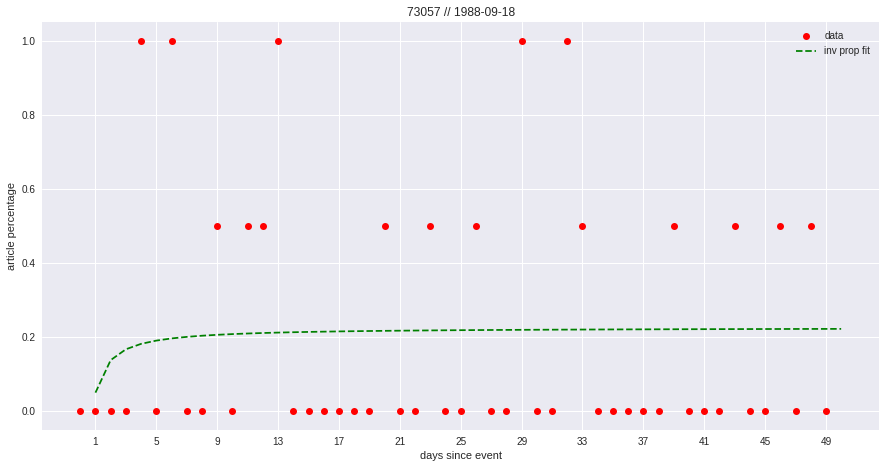

constant of proportionality:  -0.18656130895202594


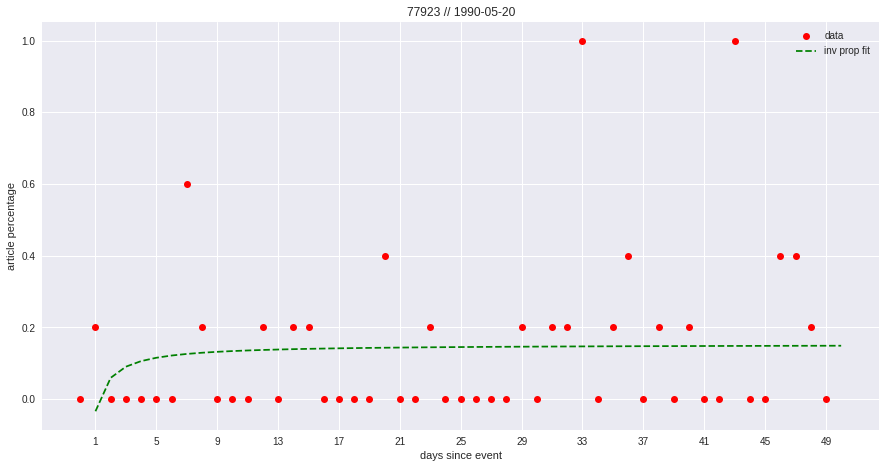

constant of proportionality:  -0.188188900350156


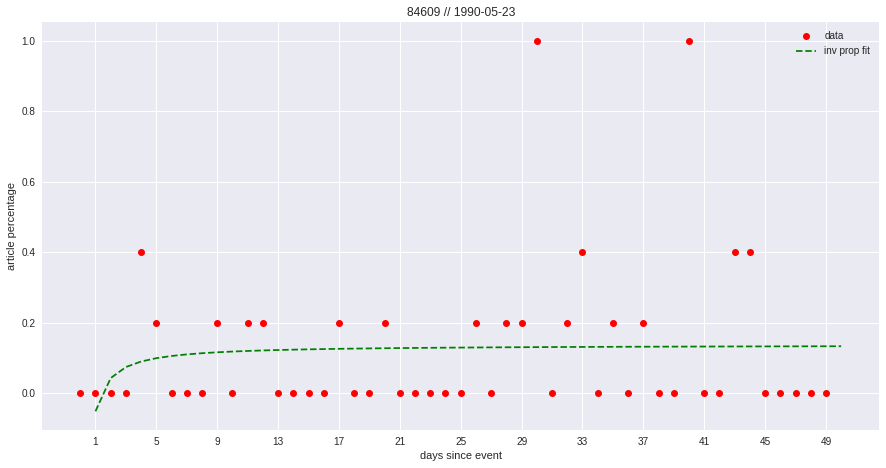

constant of proportionality:  -0.20891847217987292


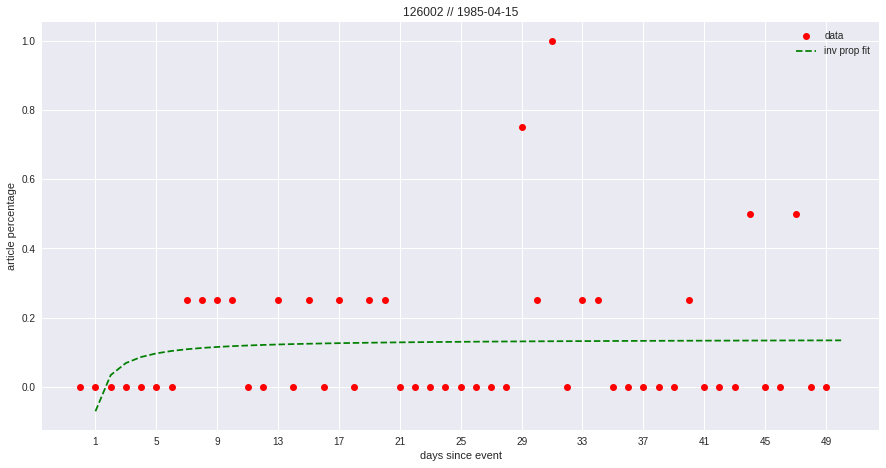

In [37]:
#@title Identity and Timecourses of Events With Fit Parameters Within Specified Intervals { run: "auto" }
source = 'cleanedarticles3.jl' #@param {type:"string"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
nyears = 5 #@param {type:"integer"}
startInterval = -.256 #@param {type:"number"}
endInterval = -.156 #@param {type:"number"}
startyear = 1985 #@param {type:"slider", min:1970, max:2014, step:1}
startAtFirstArticleInstead = False #@param {type:"boolean"}
percentage =2
    
# preprocessing the dataset
countsbydays, eventyears = [], []
for each in articleCountsByDay:
    if np.sum(articleCountsByDay[each][source]) < 1:
        continue
    eventdate = articleCountsByDay[each]['eventdate']
    if not int(eventdate[:eventdate.find('-')]) in list(range(startyear, startyear+nyears+1,1)):
        continue
    countsbydays.append((each, articleCountsByDay[each][source]))
countsbydays = [[c[0], c[1][startday:endday]] for c in countsbydays]

# make each bin a percentage
for i in range(len(countsbydays)):
    if np.sum(countsbydays[i][1]) != 0:
        countsbydays[i][1] = [c/max(countsbydays[i][1]) for c in countsbydays[i][1]]

# derive fits for each
fits = [wrapped_curve_fit(countsbydays[i][1], range(startday, endday), func)
        for i in range(len(countsbydays))]

# identify and plot every event with a fit parameter within the specified range
for i in range(len(countsbydays)):
    if startInterval <= fits[i] <= endInterval:
        databaseindex = countsbydays[i][0]
        
        eventdate = articleCountsByDay[databaseindex]['eventdate']
        eventdate = eventdate[:eventdate.rfind(' ')]

        # data to plot
        articlecounts = articleCountsByDay[databaseindex][source]
        articlecounts = articlecounts[startday:endday]
        articlecounts = np.array(articlecounts)/max(articlecounts)

        # do it!
        fig, ax = plt.subplots(figsize=(15,7.5))
        ax.plot(articlecounts, 'ro', label='data')
        plt.ylabel('article {}'.format('percentage' if percentage else 'count'))
        plt.xlabel('days since event')
        plt.title(databaseindex + ' // ' + eventdate)

        try:
            popt, pcov = curve_fit(func, range(startday, endday), articlecounts)
            print ('constant of proportionality: ', popt[0])
            plt.plot(range(startday, endday), func(np.array(range(startday, endday)), *popt), 'g--', label='inv prop fit')
            plt.xticks(np.arange(startday, endday, 4), np.arange(startday, endday, 4))
            plt.legend()
            plt.show()

        except RuntimeError:
            print('Could not fit.')
            plt.legend()
            plt.show()

## Overall Time Course Analyses

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


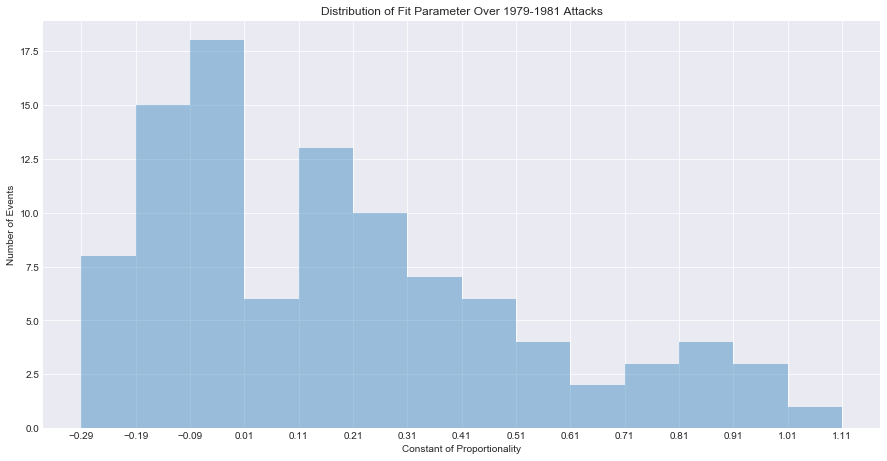

In [15]:
#@title Histogram of Fit Parameter over Time Period { run: "auto" }
source = 'cleanedarticles3.jl' #@param {type:"string"}
binSize = .1 #@param {type:"number"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
nyears = 2 #@param {type:"integer"}
startyear = 1979 #@param {type:"slider", min:1970, max:2014, step:1}
startAtFirstArticleInstead = False #@param {type:"boolean"}
    
# preprocessing the dataset
countsbydays, eventyears = [], []
for each in articleCountsByDay:
    if np.sum(articleCountsByDay[each][source]) < 1:
        continue
    countsbydays.append(articleCountsByDay[each][source])
    eventdate = articleCountsByDay[each]['eventdate']
    eventyears.append(int(eventdate[:eventdate.find('-')]))
countsbydays, eventyears = np.array(countsbydays), np.array(eventyears)
countsbydays = countsbydays.astype(float)
countsbydays = countsbydays[:,startday:endday]

# make each bin a percentage
for i in range(np.shape(countsbydays)[0]):
    if np.sum(countsbydays[i,:]) != 0:
        countsbydays[i,:] = countsbydays[i,:]/max(countsbydays[i,:])

# subset by time period
articlecounts = countsbydays[np.logical_and(eventyears>=startyear,
                                            eventyears<startyear+nyears),:]

# derive fits for each
fits = [wrapped_curve_fit(articlecounts[i], range(startday, endday), func)
        for i in range(np.shape(articlecounts)[0])]

# histogram of the result
intervals = np.arange(min(fits), max(fits), binSize)
fig, ax = plt.subplots(figsize=(15, 7.5))
plot = sns.distplot(fits, ax=ax, bins=intervals, kde=False)
plot.set_xticks(np.arange(min(fits), max(fits), .1))
plot.set_xlabel('Constant of Proportionality')
plot.set_ylabel('Number of Events')
titlestring = 'Distribution of Fit Parameter Over {}-{} Attacks'.format(startyear, startyear+nyears)
#if excludeYearsBeginningAt != 0 or excludeYearsEndingAt != 0:
#    titlestring += f' (Excluding {excludeYearsBeginningAt} to {excludeYearsEndingAt})'
plot.set_title(titlestring)
plt.show()

percentage: True
constant of proportionality:  0.38170251668429056
mean of constants of proportionality: 0.38170251653359666 +/- 0.1122636001798451


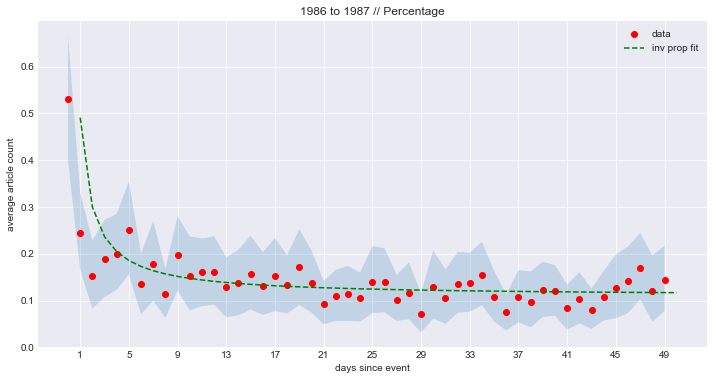

In [28]:
#@title Mean Time Course Over Arbitrary Time Period { run: "auto" }
source = 'cleanedarticles2.jl' #@param {type:"string"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
nyears = 1 #@param {type:"integer"}
startyear = 1986 #@param {type:"slider", min:1970, max:2014, step:1}

for percentage in ['True']:
    print('percentage:', percentage)
    
    # preprocessing the dataset
    countsbydays, eventyears = [], []
    for each in articleCountsByDay:
        if np.sum(articleCountsByDay[each][source]) < 1:
            continue
        countsbydays.append(articleCountsByDay[each][source])
        eventdate = articleCountsByDay[each]['eventdate']
        eventyears.append(int(eventdate[:eventdate.find('-')]))
    countsbydays, eventyears = np.array(countsbydays), np.array(eventyears)
    countsbydays = countsbydays.astype(float)
    countsbydays = countsbydays[:,startday:endday]
    
    # make each bin a percentage if percentage is set to True
    if percentage == 'True':
        for i in range(np.shape(countsbydays)[0]):
            if np.sum(countsbydays[i,:]) != 0:
                countsbydays[i,:] = countsbydays[i,:]/max(countsbydays[i,:])
    elif percentage == 'Old':
        for i in range(np.shape(countsbydays)[0]):
            if np.sum(countsbydays[i,:]) != 0:
                countsbydays[i,:] = countsbydays[i,:]/sum(countsbydays[i,:])
       
    # go!
    # for startyear in range(startyear, 2015-nyears+1):
    articlecounts = countsbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
    meancounts = np.mean(articlecounts, axis=0)
    bootstrap = [bootstrapCI(articlecounts[:,i], np.mean, 1000) for i in range(np.shape(articlecounts)[1])]
    lower_bound, upper_bound = [b[1] for b in bootstrap], [b[2] for b in bootstrap]

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(meancounts, 'ro', label='data')
    plt.ylabel('average article count')
    plt.xlabel('days since event')
    plt.title(str(startyear) + ' to ' + str(startyear+nyears) + ' // ' + ('Percentage' if percentage else 'Raw'))
    plt.fill_between(np.arange(endday-startday), lower_bound, upper_bound, alpha=.2)

    try:
        popt, pcov = curve_fit(func, range(startday, endday), meancounts)#, p0=(1, 1e-6, 1))
        print ('constant of proportionality: ', popt[0])
        fits = [wrapped_curve_fit(articlecounts[i], range(startday, endday), func) for i in range(np.shape(articlecounts)[0])]
        print('mean of constants of proportionality: {} +/- {}'.format(np.nanmean(fits), np.nanmean(fits)-bootstrapCI(fits, np.nanmean, 1000)[1]))
        plt.plot(range(startday, endday), func(np.array(range(startday, endday)), *popt), 'g--', label='inv prop fit')
        plt.xticks(np.arange(startday, endday, 4), np.arange(startday, endday, 4))
        plt.legend()
        plt.show()

    except RuntimeError:
        print('Could not fit.')
        plt.legend()
        plt.show()

percentage: True


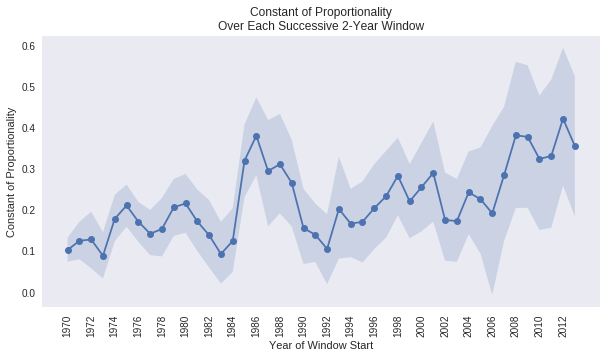

percentage: True


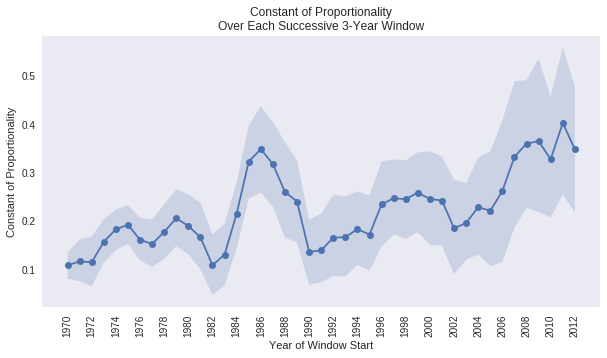

In [22]:
#@title Constant of Proportionality Over Years
source = 'cleanedarticles3.jl' #@param {type:"string"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
#nyears = 2 #@param {type:"integer"}
inityear = 1970 #@param {type:"integer"}
maxYearWindow = 3 #@param {type:"integer"}

# preprocessing the dataset
countsbydays, eventyears = [], []
for each in articleCountsByDay:
    if np.sum(articleCountsByDay[each][source]) < 4:
        continue
    countsbydays.append(articleCountsByDay[each][source])
    eventdate = articleCountsByDay[each]['eventdate']
    eventyears.append(int(eventdate[:eventdate.find('-')]))
countsbydays, eventyears = np.array(countsbydays), np.array(eventyears)
countsbydays = countsbydays.astype(float)
countsbydays = countsbydays[:,startday:endday]

# create percentagebydays
percentagesbydays = np.copy(countsbydays)
for i in range(np.shape(percentagesbydays)[0]):
    if np.sum(percentagesbydays[i,:]) != 0:
        percentagesbydays[i,:] = percentagesbydays[i,:]/max(percentagesbydays[i,:])

# an old version too
oldpercentagesbydays = np.copy(countsbydays)
for i in range(np.shape(oldpercentagesbydays)[0]):
    if np.sum(oldpercentagesbydays[i,:]) != 0:
        oldpercentagesbydays[i,:] = oldpercentagesbydays[i,:]/sum(oldpercentagesbydays[i,:])
        
for nyears in range(2, maxYearWindow+1):
    for percentage in ['True']:
        halflifes, linearcors, lower_bound, upper_bound = [], [], [], []

        # go!
        for startyear in range(inityear, 2015-nyears+1):
            if percentage == 'Old':
                articlecounts = oldpercentagesbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
            elif percentage == 'True':
                articlecounts = percentagesbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
            else:
                articlecounts = countsbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
            meancounts = np.mean(articlecounts, axis=0)

            # constant of proportionality
            try:
                popt, pcov = curve_fit(func, range(startday, endday), meancounts)
                halflifes.append(popt[0])
                fits = [wrapped_curve_fit(articlecounts[i], range(startday, endday), func) for i in range(np.shape(articlecounts)[0])]
                bootstrap = bootstrapCI(fits, np.nanmean, 1000)
                lower_bound.append(bootstrap[1])
                upper_bound.append(bootstrap[2])
            except RuntimeError:
                halflifes.append(0)
        
        print('percentage:', percentage)
        #plt.figure(figsize=(20,5))
        #plt.subplot(121)
        #plt.plot(np.arange(inityear,inityear+len(linearcors)),linearcors, marker='o')
        #plt.xticks(np.arange(inityear,2015-nyears+1,2), rotation='vertical')
        #plt.title('Linear Correlation Over\n Each Successive ' + str(nyears) + '-Year Window')
        #plt.ylabel('Linear Correlation')
        #plt.xlabel('Year of Window Start')
        #plt.grid()
        #plt.show()

        #plt.subplot(111)
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(inityear,inityear+len(halflifes)),halflifes, marker='o')
        plt.xticks(np.arange(inityear,2015-nyears+1,2), rotation='vertical')
        plt.title('Constant of Proportionality\nOver Each Successive ' + str(nyears) + '-Year Window')
        plt.ylabel('Constant of Proportionality')
        plt.xlabel('Year of Window Start')
        plt.fill_between(np.arange(inityear,inityear+len(halflifes)), lower_bound, upper_bound, alpha=.2)
        plt.grid()

        plt.show()

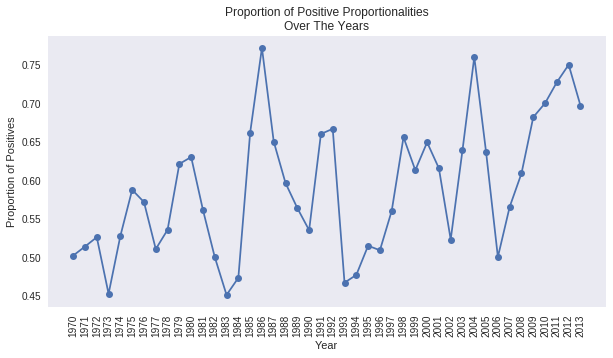

In [19]:
#@title Proportion of Positive Proportionalities Over Years
source = 'cleanedarticles3.jl' #@param {type:"string"}
startday = 1 #@param {type:"integer"}
endday = 51 #@param {type:"integer"}
nyears = 2 #@param {type:"integer"}
inityear = 1970 #@param {type:"integer"}

# preprocessing the dataset
countsbydays, eventyears = [], []
for each in articleCountsByDay:
    if np.sum(articleCountsByDay[each][source]) < 4:
        continue
    countsbydays.append(articleCountsByDay[each][source])
    eventdate = articleCountsByDay[each]['eventdate']
    eventyears.append(int(eventdate[:eventdate.find('-')]))
countsbydays, eventyears = np.array(countsbydays), np.array(eventyears)
countsbydays = countsbydays.astype(float)
countsbydays = countsbydays[:,startday:endday]

# create percentagebydays
percentagesbydays = np.copy(countsbydays)
for i in range(np.shape(percentagesbydays)[0]):
    if np.sum(percentagesbydays[i,:]) != 0:
        percentagesbydays[i,:] = percentagesbydays[i,:]/max(percentagesbydays[i,:])

# an old version too
oldpercentagesbydays = np.copy(countsbydays)
for i in range(np.shape(oldpercentagesbydays)[0]):
    if np.sum(oldpercentagesbydays[i,:]) != 0:
        oldpercentagesbydays[i,:] = oldpercentagesbydays[i,:]/sum(oldpercentagesbydays[i,:])
        
for percentage in ['True']:
    halflifes, linearcors, lower_bound, upper_bound = [], [], [], []

    # go!
    proportions = []
    for startyear in range(inityear, 2015-nyears+1):
        if percentage == 'Old':
            articlecounts = oldpercentagesbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
        elif percentage == 'True':
            articlecounts = percentagesbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
        else:
            articlecounts = countsbydays[np.logical_and(eventyears>=startyear, eventyears<startyear+nyears),:]
        meancounts = np.mean(articlecounts, axis=0)

        # constant of proportionality
        try:
            popt, pcov = curve_fit(func, range(startday, endday), meancounts)
            halflifes.append(popt[0])
            fits = np.array([wrapped_curve_fit(articlecounts[i], range(startday, endday), func) for i in range(np.shape(articlecounts)[0])])
            bootstrap = bootstrapCI(fits, np.nanmean, 1000)
            lower_bound.append(bootstrap[1])
            upper_bound.append(bootstrap[2])
        except RuntimeError:
            halflifes.append(0)
        proportions.append(np.mean(fits>0))
        
plt.figure(figsize=(10,5))
plt.plot(np.arange(inityear,inityear+len(proportions)),proportions, marker='o')
plt.xticks(np.arange(inityear,2015-nyears+1,1), rotation='vertical')
plt.title('Proportion of Positive Proportionalities\nOver The Years')
plt.ylabel('Proportion of Positives')
plt.xlabel('Year')
# plt.fill_between(np.arange(inityear,inityear+len(halflifes)), lower_bound, upper_bound, alpha=.2)
plt.grid()

plt.show()

In [ ]:
%%html
